In [1]:
from solar_mapper.dataset.sentinel_2 import get_example_with_segmentation_map
from solar_mapper.dataset.utils import get_global_pv_mapping_polygons
import datetime
from PIL import Image
import os

In [2]:
polygons = get_global_pv_mapping_polygons()

In [3]:
polygons['train'][1000]

{"geometry": {"coordinates": [[[95.204096, 36.375331], [95.192227, 36.375246], [95.1922, 36.378896], [95.204045, 36.378957], [95.204096, 36.375331]]], "type": "Polygon"}, "properties": {"Country": "China", "Date": "2017-10-02 10:16:12", "Polygon Source": "Satellite shows", "Project": "Chaohu A", "Province": "Anhui", "WRI_ref": "nan"}, "type": "Feature"}

In [4]:
# Generate random examples with the train polygons up to 2018, and add mask from PV site
train_example = get_example_with_segmentation_map(polygons['train'][0],
                                                  start_time=datetime.datetime(2016, 1, 1),
                                                  end_time=datetime.datetime(2018, 1, 1),
                                                  search_delta=datetime.timedelta(days=90),
                                                  num_samples=8)

In [5]:
print(train_example)

<xarray.Dataset>
Dimensions:           (y: 10980, x: 10980, time: 8)
Coordinates:
  * y                 (y) float64 3.5e+06 3.5e+06 3.5e+06 ... 3.39e+06 3.39e+06
  * x                 (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
    spatial_ref       int32 32650
  * time              (time) datetime64[ns] 2017-10-09T02:57:21.026000 ... 20...
Data variables: (12/17)
    AOT               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B01               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B02               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ...                ...
    B12       

In [6]:
train_example.keys()

KeysView(<xarray.Dataset>
Dimensions:           (y: 10980, x: 10980, time: 8)
Coordinates:
  * y                 (y) float64 3.5e+06 3.5e+06 3.5e+06 ... 3.39e+06 3.39e+06
  * x                 (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
    spatial_ref       int32 32650
  * time              (time) datetime64[ns] 2017-10-09T02:57:21.026000 ... 20...
Data variables: (12/17)
    AOT               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B01               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B02               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05               (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ...                ...
    B

In [7]:
import matplotlib.pyplot as plt
import numpy as np
print(train_example['visual'].shape)

(8, 10980, 10980)


In [8]:
seg_mask = train_example['segmentation_map']
# How many pixels are non-zero in the segmentation map? Should come out to 394
print(f"Number of non-zero pixels in segmentation map: {seg_mask.sum().values}")

Number of non-zero pixels in segmentation map: 394


In [9]:
import os

if not os.path.exists('train_folder'):
    os.makedirs('train_folder')

In [10]:
seg_mask_pixels = seg_mask.sum().values
assert seg_mask_pixels >0

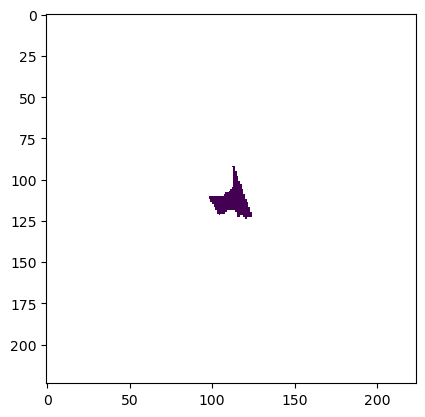

In [11]:
import matplotlib.pyplot as plt
import numpy as np
# Get the index of the first non-zero element
non_zero_idx = np.nonzero(seg_mask.values)
# Get the center of the non-zero elements
non_zero_center = np.mean(non_zero_idx, axis=1)
# Get the cutout
seg_mask_cutout = seg_mask.where(seg_mask != 0).isel(x=slice(int(non_zero_center[1]-112), int(non_zero_center[1]+112)), y=slice(int(non_zero_center[0]-112), int(non_zero_center[0]+112)))
plt.imshow(seg_mask_cutout)
plt.show()

In [12]:
def rescale_to_8bit(array, min_value=None, max_value=None):
    if min_value is None:
        min_value = np.min(array)
    if max_value is None:
        max_value = np.max(array)
    
    # Normalize to 0-1 range
    normalized = (array - min_value) / (max_value - min_value)
    
    # Rescale to 0-255 range
    rescaled = (normalized * 255).astype(np.uint8)
    
    return rescaled

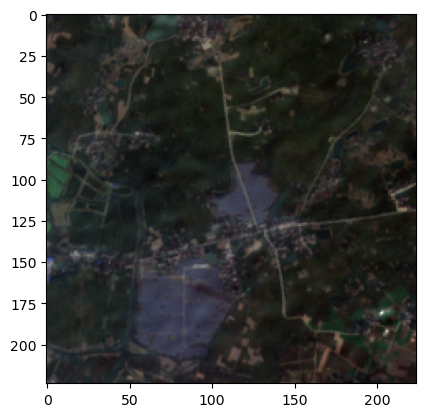

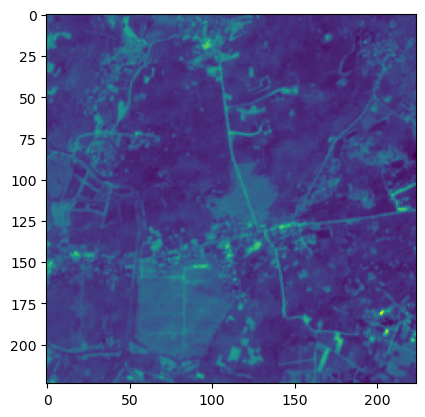

In [13]:
# Visual
vis_arr = train_example['visual'].isel(time=3,x=slice(int(non_zero_center[1]-112), int(non_zero_center[1]+112)), y=slice(int(non_zero_center[0]-112), int(non_zero_center[0]+112))).values
vis_arr_blue = train_example['B02'].isel(time=3,x=slice(int(non_zero_center[1]-112), int(non_zero_center[1]+112)), y=slice(int(non_zero_center[0]-112), int(non_zero_center[0]+112))).values
vis_arr_green = train_example['B03'].isel(time=3,x=slice(int(non_zero_center[1]-112), int(non_zero_center[1]+112)), y=slice(int(non_zero_center[0]-112), int(non_zero_center[0]+112))).values
vis_arr_red = train_example['B04'].isel(time=3,x=slice(int(non_zero_center[1]-112), int(non_zero_center[1]+112)), y=slice(int(non_zero_center[0]-112), int(non_zero_center[0]+112))).values

vis_arr_blue = rescale_to_8bit(vis_arr_blue)
vis_arr_red = rescale_to_8bit(vis_arr_red)
vis_arr_green = rescale_to_8bit(vis_arr_green)

rgb_image = np.stack((vis_arr_red, vis_arr_green, vis_arr_blue), axis=-1)

# Visualize the RGB image using matplotlib
plt.imshow(rgb_image)
plt.show()

plt.imshow(vis_arr)
plt.show()

vis_img = Image.fromarray(rgb_image)
vis_img.save(os.path.join('train_folder', 'vis_img_test.png'))

In [14]:
seg_mask_8bit = (seg_mask_cutout.values * 255).astype(np.uint8)
seg_img = Image.fromarray(seg_mask_8bit)
seg_img.save(os.path.join('train_folder', 'seg_mask_test.png'))

/tmp/ipykernel_1210/2704346627.py:1: RuntimeWarning: invalid value encountered in cast
  seg_mask_8bit = (seg_mask_cutout.values * 255).astype(np.uint8)


In [15]:
np.min(vis_arr_blue), np.max(vis_arr_blue)

(0, 255)

In [16]:
import xarray as xr
import rasterio

slice_len=112
bands_of_interest = ['B02', 'B03', 'B04', 'B8A', 'B11', 'B12']
subset = train_example[bands_of_interest].isel(time=slice(0, 3), x=slice(int(non_zero_center[1]-112), int(non_zero_center[1]+112)), y=slice(int(non_zero_center[0]-112), int(non_zero_center[0]+112))).values

# Step 2: Save the subsetted data as a TIFF file
output_file = "train_folder/test.tif"

# Using rasterio to save the data
with rasterio.open(output_file, 'w', driver='GTiff', height=224, width=224, count=len(bands_of_interest)*3, dtype=str(train_example['B02'].dtype)) as dst:
    for band_idx, band_name in enumerate(bands_of_interest, start=1):
        for t in range(3):
            dst.write(train_example[band_name].isel(time=t,x=slice(int(non_zero_center[1]-slice_len), int(non_zero_center[1]+slice_len)), y=slice(int(non_zero_center[0]-slice_len), int(non_zero_center[0]+slice_len))).values, band_idx + t*len(bands_of_interest))

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [17]:
with rasterio.open(output_file) as src:
    data = src.read()
    print(data.shape)

(18, 224, 224)


/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [18]:
def create_tif_sample(polygons, polygon_number):
    slice_len=112
    ## Step 1. Get the top 8 time samples for this polygon
    train_example = get_example_with_segmentation_map(polygons['train'][int(polygon_number)],
                                                  start_time=datetime.datetime(2016, 1, 1),
                                                  end_time=datetime.datetime(2018, 1, 1),
                                                  search_delta=datetime.timedelta(days=90),
                                                  num_samples=8)
    ## Step 2 - Get Seg Mask and Ensure it is valid
    seg_mask = train_example['segmentation_map']
    seg_mask_pixels = seg_mask.sum().values
    assert seg_mask_pixels >0
    
    ## Step 3 - Get the seg mask cutout
    # Get the index of the first non-zero element
    non_zero_idx = np.nonzero(seg_mask.values)
    # Get the center of the non-zero elements
    non_zero_center = np.mean(non_zero_idx, axis=1)
    # Get the cutout
    seg_mask_cutout = seg_mask.where(seg_mask != 0).isel(x=slice(int(non_zero_center[1]-slice_len), int(non_zero_center[1]+slice_len)), y=slice(int(non_zero_center[0]-slice_len), int(non_zero_center[0]+slice_len))).values
    
    ## Step 4 - Get the visual sample of the image for timestep 0
    visual_arr = train_example['visual'].isel(time=0,x=slice(int(non_zero_center[1]-slice_len), int(non_zero_center[1]+slice_len)), y=slice(int(non_zero_center[0]-slice_len), int(non_zero_center[0]+slice_len))).values
    
    ## Step 5 - Get the RGB image
    blue_arr = train_example['B02'].isel(time=0,x=slice(int(non_zero_center[1]-slice_len), int(non_zero_center[1]+slice_len)), y=slice(int(non_zero_center[0]-slice_len), int(non_zero_center[0]+slice_len))).values
    green_arr = train_example['B03'].isel(time=0,x=slice(int(non_zero_center[1]-slice_len), int(non_zero_center[1]+slice_len)), y=slice(int(non_zero_center[0]-slice_len), int(non_zero_center[0]+slice_len))).values
    red_arr = train_example['B04'].isel(time=0,x=slice(int(non_zero_center[1]-slice_len), int(non_zero_center[1]+slice_len)), y=slice(int(non_zero_center[0]-slice_len), int(non_zero_center[0]+slice_len))).values
    blue_arr = rescale_to_8bit(blue_arr)
    green_arr = rescale_to_8bit(green_arr)
    red_arr = rescale_to_8bit(red_arr)

    rgb_arr = np.stack((red_arr, green_arr, blue_arr), axis=-1)
    
    ## Step 6 - Save the mask and the visuals
    seg_mask_8bit = (seg_mask_cutout * 255).astype(np.uint8)
    seg_img = Image.fromarray(seg_mask_8bit)
    seg_img.save(os.path.join('train_folder', f'seg_mask_{polygon_number}.png'))
    vis_img = Image.fromarray(visual_arr)
    vis_img.save(os.path.join('train_folder', f'vis_img_{polygon_number}.png'))
    rgb_img = Image.fromarray(rgb_arr)
    rgb_img.save(os.path.join('train_folder', f'rgb_img_{polygon_number}.png'))
    
    ## Step 7 - TIF array with 6 bands and the first 3 timesteps
    bands_of_interest = ['B02', 'B03', 'B04', 'B8A', 'B11', 'B12']
    output_file = f"train_folder/data_{polygon_number}.tif"

    # Using rasterio to save the data
    with rasterio.open(output_file, 'w', driver='GTiff', height=224, width=224, count=len(bands_of_interest)*3, dtype=str(train_example['B02'].dtype)) as dst:
        for band_idx, band_name in enumerate(bands_of_interest, start=1):
            for t in range(3):
                dst.write(train_example[band_name].isel(time=t,x=slice(int(non_zero_center[1]-slice_len), int(non_zero_center[1]+slice_len)), y=slice(int(non_zero_center[0]-slice_len), int(non_zero_center[0]+slice_len))).values, band_idx + t*len(bands_of_interest))

In [19]:
polygons = get_global_pv_mapping_polygons()

In [20]:
create_tif_sample(polygons, 0)

/tmp/ipykernel_1210/192493697.py:36: RuntimeWarning: invalid value encountered in cast
  seg_mask_8bit = (seg_mask_cutout * 255).astype(np.uint8)
/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [21]:
polygons = get_global_pv_mapping_polygons()
for i in range(0,2000):
    try:
        create_tif_sample(polygons, i)
    except:
        print("Couldn't process", i)

KeyboardInterrupt: 